**<h1><center>Machine Learning For Signal Processing (ENGR-E 511) 
<br>Homework 4 , Spring 2022</h1>**

**Name: Anitha Ganapathy** <br>
**Email: aganapa@iu.edu** <br>


___

Organizing the imports

In [1]:
# Import the necessary libraries

from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import matplotlib.mlab as mlab
import librosa
import soundfile as sf
from IPython.display import Audio
import cmath, math
import scipy.io  # to read .mat files
import seaborn as sns
from numpy.core.fromnumeric import size
import scipy
from google.colab import drive

drive.mount('/content/drive')  

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
dirpath = '/content/drive/MyDrive/MLSP_data/'
!ls $dirpath

 eeg.mat     'HW_2 data'   MDS_pdist.mat   trs.wav
'HW_1 data'  'HW_3 data'   trn.wav	   x_nmf.wav


## **P1: KNN Source Separation**

In [3]:
trs_file = dirpath + 'trs.wav'
trn_file = dirpath + 'trn.wav'
trs, sr = librosa.load(trs_file , sr = None)
trn, sr = librosa.load(trn_file , sr = None)

In [4]:
trs.shape, trn.shape

((506166,), (506166,))

### Original S and N i.e piano and ocean signals

In [5]:
Audio(trs, rate = sr)

In [6]:
Audio(trn, rate = sr)

In [7]:
hop_length = 512

In [8]:
S = librosa.stft(trs,  n_fft=1024, hop_length  = hop_length,  window='hann')
N = librosa.stft(trn,  n_fft=1024, hop_length  = hop_length,  window='hann')

In [9]:
S.shape , N.shape

((513, 989), (513, 989))

### Matrix G, the magnitude spectrogram of trs.wav+trn.wav.

In [10]:
S_abs = np.abs(S)
N_abs = np.abs(N)

In [11]:
G = S_abs + N_abs
G.shape

(513, 989)

In [12]:
Audio(librosa.istft(G), rate = sr)

### Ideal Binary Masks (IBM), 

**B** 

$$
\boldsymbol{B}_{f, t}= \begin{cases}1 & \text { if } \boldsymbol{S}_{f, t} \geq \boldsymbol{N}_{f, t} \\ 0 & \text { otherwise }\end{cases}
$$
 
 The hope is that<br> 
 **S ≈ B ⊙ G**

In [13]:
B = (S_abs > N_abs).astype(int)
B.shape

(513, 989)

In [14]:
B

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]])

### Load x_nmf.wav and convert it into a complex-valued spectrogram X and its magnitudes Y

In [15]:
x_nmf_file = dirpath + 'x_nmf.wav'
x_nmf, sr = librosa.load(x_nmf_file , sr = None)

In [16]:
x_nmf.shape

(66560,)

In [17]:
Audio(x_nmf, rate = sr)

In [18]:
X = librosa.stft(x_nmf,  n_fft=1024, hop_length  = hop_length,  window='hann')

In [19]:
X.shape

(513, 131)

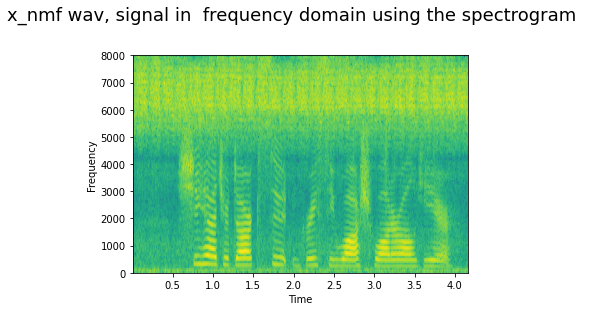

In [20]:
plt.specgram(x_nmf ,Fs = sr)
plt.suptitle("x_nmf wav, signal in  frequency domain using the spectrogram ", y=1.05, fontsize=18)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()

In [21]:
Y = np.abs(X)
Y.shape

(513, 131)

In [22]:
G.shape

(513, 989)

In [23]:
def knn_source_separation(Y, G, k,B, X):
  print("Y shape :", Y.shape)  # Y shape : (513, 131)
  print("G shape :", G.shape)  # G shape : (513, 987)

  euc_dist = np.zeros((Y.shape[1],  G.shape[1]))

  # we compare each column of Y with all columns in G to find out knearest neighbors.
  for i in range(Y.shape[1]):    # (columns : 131)
    for j in range(G.shape[1]):  # (columns : 989)
      euc_dist[i][j] = np.sqrt(np.sum((Y[:, i] - G[:, j]) ** 2))
    
  sorted_distances = euc_dist.argsort()
  knn_indexes      = sorted_distances[:,0:k]         # k indexes with shortest distance
  print("knn_indexes shape : ", knn_indexes.shape)   # knn_indexes shape :  (131, k)
  # print(knn_indexes)

  # D = IBM of the test signal
  D = np.zeros((Y.shape[1],Y.shape[0]))   # Y shape : (513, 131)
                                          # B shape : (513, 989)
  
  # By using the nearest neighbor indices, I can collect the IBM vectors 
  # from B, i.e. {B:,i1 ,B:,i2 , · · · ,B:,ik}.

  for m in range(knn_indexes.shape[0]):   # 131  for every row
    b_val = np.zeros((513,1))
    for n in range(knn_indexes.shape[1]):  # 20  for every column index
      # b_val.append(np.median(np.sort(B[:, knn_indexes[m][n]])))
      col_index = int(knn_indexes[m][n])
      median_value = B[:,col_index]
      median_value =  median_value.reshape((median_value.shape[0],1))
      b_val = np.hstack((b_val,median_value))
    median_k = np.median(b_val[:,1:], axis = 1)
    D[m,:] = median_k    

  print(f'D.T shape : {D.T.shape}')
  print(f'X shape : {X.shape}')  
  S_recov = np.multiply(D.T,X)  
  print(f'S_recov shape : {S_recov.shape}')
  return S_recov

In [24]:
source_recov = knn_source_separation(Y, G, 12,B, X)

Y shape : (513, 131)
G shape : (513, 989)
knn_indexes shape :  (131, 12)
D.T shape : (513, 131)
X shape : (513, 131)
S_recov shape : (513, 131)


### **X_nmf recovered source signal**

In [25]:
source_actual = librosa.istft(source_recov, hop_length = hop_length)
Audio(source_actual, rate = sr)

## **P2: Motor Imagery**

https://www.pinecone.io/learn/locality-sensitive-hashing/

In [26]:
!ls $dirpath

 eeg.mat     'HW_2 data'   MDS_pdist.mat   trs.wav
'HW_1 data'  'HW_3 data'   trn.wav	   x_nmf.wav


In [27]:
eeg_mat = scipy.io.loadmat(dirpath+'eeg.mat')

In [28]:
print(eeg_mat.keys())
# print(mat.get('L'))

dict_keys(['__header__', '__version__', '__globals__', 'x_te', 'x_train', 'y_te', 'y_train'])


In [29]:
train_x = eeg_mat.get('x_train')
train_y = eeg_mat.get('y_train')
test_x =  eeg_mat.get('x_te')
test_y =  eeg_mat.get('y_te')

In [30]:
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((768, 3, 112), (112, 1), (768, 3, 28), (28, 1))

In [31]:
print(train_x[:,0,:].reshape(-1).shape)
train_x[:, 0, :].shape

(86016,)


(768, 112)

https://musicinformationretrieval.com/stft.html

### **Blackman window**

In [32]:
def blackman_window(data, N, hop_length):
    blackman = np.blackman(N)
    new_data = []
    hop_counter = 0
    
    while hop_counter + N <= len(data):
        frame = data[hop_counter: hop_counter+N]
        vector = np.multiply(frame.T, blackman)
        new_data.append(vector)
        hop_counter = hop_counter + hop_length
    return np.array(new_data).T

In [33]:
def stft_for_mu_freq(data):
    stft_mu_vector = []
    dft_eeg_sig = np.fft.fft(np.eye(64))
    for i in range(3):
        channel_window = blackman_window(data[:,i], 64, 48)
        stft_mu = np.abs(np.dot(dft_eeg_sig, channel_window))[2:7,:].reshape(-1,1)
        stft_mu_vector.append(stft_mu)
        
    return np.array(stft_mu_vector).reshape(-1,1)

Creating the Z matrix

In [34]:
Z_train = []
Z_test = []

for i in range(train_x.shape[2]):
    Z_train.append(stft_for_mu_freq(train_x[:,:,i]))

for i in range(test_x.shape[2]):
    Z_test.append(stft_for_mu_freq(test_x[:,:,i]))

print(len(Z_train), len(Z_test))
print(len(Z_train[0]), len(Z_test[0]))

112 28
225 225


In [35]:
Z_train = np.array(Z_train).T.reshape(225,112)
Z_test = np.array(Z_test).T.reshape(225,28)
print(Z_train.shape, Z_test.shape)

(225, 112) (225, 28)


In [36]:
print(Z_train.shape, Z_test.shape)

(225, 112) (225, 28)


In [37]:
def matrix_A_calc(l,M):
    
    np.random.seed(3232)
    A = np.random.uniform(-1,1,l)
    for i in range(len(M) - 1):
        A = np.vstack((A,np.random.uniform(-1,1,l)))
    sum_A = [sum(A[i]) for i in range(len(M))]
    sum_A = np.array(sum_A)
    inv_sum_A = 1/sum_A
    
    B = A * inv_sum_A[:, np.newaxis]    
    return B.T

def matrix_Y_calc(A,Z):
    Y = np.dot(A,Z)
    Y_sign = np.sign(Y)
    return Y,Y_sign

def hamming_dist(s1,s2):
    return np.count_nonzero(s1 != s2)

def distance(Y,Y_test):
    
    distance = np.zeros((28,112))
    for i in range(distance.shape[0]):
        for j in range(distance.shape[1]):
            distance[i][j] = hamming_dist(Y_test[:,i],Y[:,j])
    
    sorted_distance = distance.argsort()
    final_index = np.zeros((Y_test.shape[1],Y.shape[1]))
    for i in range(Y_test.shape[1]):
        for j in range(Y.shape[1]):
            index = sorted_distance[i][j]
            final_index[i][j] = train_y[index,0]
            
    return final_index


### KNN algo for the given k = 12

In [38]:
l_list =[] 
acc_list = []

k = 12
for i in range(2,21,2):
      l = i
      A = matrix_A_calc(l,Z_train)
      Y,Y_sign = matrix_Y_calc(A,Z_train)
      Y_test,Y_test_sign = matrix_Y_calc(A,Z_test)
      knn_dist_sorted = distance(Y_sign,Y_test_sign)
      kNearestNeighbours = knn_dist_sorted[:,0:k]        
      final_y_test = np.zeros((test_y.shape[0],1))
      for p in range(0,28):
          final_y_test[p] = np.median(kNearestNeighbours[p,:])

      count = 0    
      for p in range(0,28):
          if final_y_test[p] == test_y[p]:
              count+=1

      accuracy = count/28
      l_list.append(i)
      
      acc_list.append(accuracy)


### LSH and accuracy values

In [39]:
df = pd.DataFrame(list(zip(l_list, acc_list)), columns= ['LSH', 'Acc'])
df

LSH       Acc
0    2  0.250000
1    4  0.535714
2    6  0.535714
3    8  0.500000
4   10  0.607143
5   12  0.428571
6   14  0.750000
7   16  0.357143
8   18  0.535714
9   20  0.500000

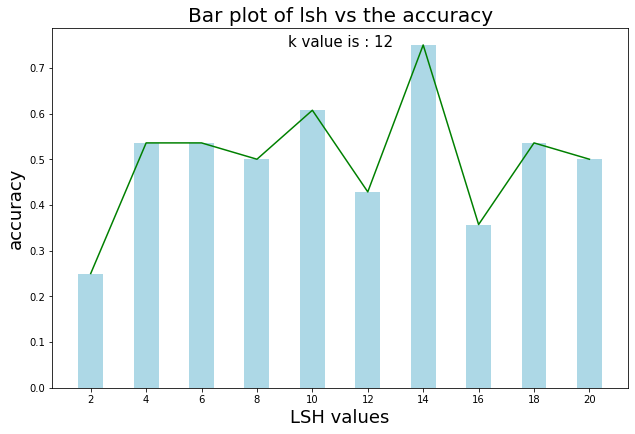

In [40]:
# plot the bar graph

fig = plt.figure(figsize=(8,5))
ax = fig.add_axes([0,0,1,1])

plt.bar(l_list,acc_list, color ='lightblue',width = 0.9)
plt.plot(l_list,acc_list, color ='green')
plt.title("Bar plot of lsh vs the accuracy", fontsize = 20)
plt.suptitle("k value is : " +str(k), fontsize = 15)
plt.xticks(l_list)
plt.xlabel("LSH values", fontsize = 18)
plt.ylabel("accuracy", fontsize = 18)
plt.show()

## **P3: Multidimensional Scaling**

In [41]:
!ls $dirpath

 eeg.mat     'HW_2 data'   MDS_pdist.mat   trs.wav
'HW_1 data'  'HW_3 data'   trn.wav	   x_nmf.wav


In [42]:
mat = scipy.io.loadmat(dirpath+'MDS_pdist.mat')

In [43]:
print(mat.keys())
print(mat.get('L'))

dict_keys(['__header__', '__version__', '__globals__', 'L'])
[[0.00000000e+00 5.44312269e+00 2.67017193e+01 ... 6.07884921e+03
  6.13357512e+03 6.36068812e+03]
 [5.44312269e+00 0.00000000e+00 9.11488327e+00 ... 5.91838401e+03
  5.95547373e+03 6.16930480e+03]
 [2.67017193e+01 9.11488327e+00 0.00000000e+00 ... 5.96693055e+03
  5.97925005e+03 6.17815366e+03]
 ...
 [6.07884921e+03 5.91838401e+03 5.96693055e+03 ... 0.00000000e+00
  1.70591650e+01 4.68013768e+01]
 [6.13357512e+03 5.95547373e+03 5.97925005e+03 ... 1.70591650e+01
  0.00000000e+00 8.10373912e+00]
 [6.36068812e+03 6.16930480e+03 6.17815366e+03 ... 4.68013768e+01
  8.10373912e+00 0.00000000e+00]]


In [44]:
mds = np.array(mat.get('L'))
print("MDS Data shape: ",mds.shape)

MDS Data shape:  (996, 996)


In [45]:
mds[:5, :5]

array([[ 0.        ,  5.44312269, 26.70171934,  9.68544327, 34.16240182],
       [ 5.44312269,  0.        ,  9.11488327,  1.35115426, 12.33765582],
       [26.70171934,  9.11488327,  0.        , 10.25086119,  2.84172387],
       [ 9.68544327,  1.35115426, 10.25086119,  0.        ,  9.55474067],
       [34.16240182, 12.33765582,  2.84172387,  9.55474067,  0.        ]])

### MultiDimensional Scaling (MDS) - M08, S05

The recipe for MDS
- Convert your pairwise distance matrix $M$ into a positive definite matrix $W$
- Do eigendecomposition on the matrix $W$
- First few vectors of $UV^{1/2}$ holds recovers the locations (coordinates)

In [46]:
mds.shape

(996, 996)

In [47]:
np.max(mds) , np.min(mds)

(10289.638412636026, 0.0)

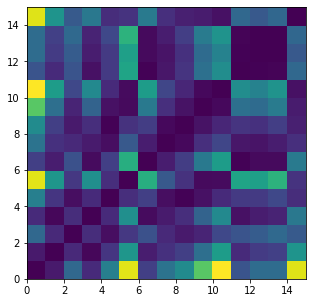

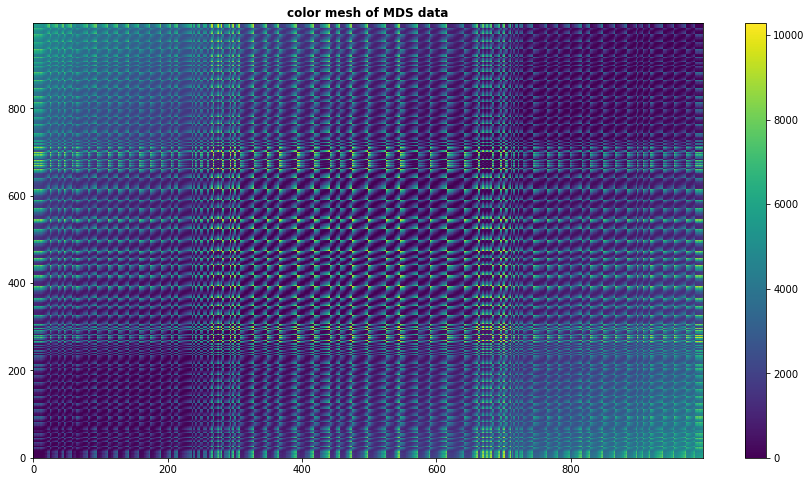

In [48]:
plt.figure(figsize=(5,5))
c= plt.pcolormesh(mds[:15, :15])
plt.show()

plt.figure(figsize=(15,8))
c= plt.pcolormesh(mds[:, :])
plt.colorbar(c)  
plt.title('color mesh of MDS data', fontweight ="bold")
plt.show()

In [49]:
np.mean(mds, axis=1).shape # row wise mean 

(996,)

In [50]:
m_bar =  np.mean(mds, axis=1) 
m_bar.shape

(996,)

In [51]:
m_tilde = mds - m_bar
m_tilde.shape

(996, 996)

In [52]:
X_mat = m_tilde - np.mean(m_tilde, axis=0) # substraction of row wise mean 

In [53]:
X_mat.shape

(996, 996)

https://github.com/swethapola/Multidimensional-Scaling/blob/master/131%20HW%204.ipynb

In [54]:
def eigen_decomposition(X, num_eigenvectors):
    max_epochs = 50
    eigen_val = []
    eigen_vec = []
    
    for i in range(num_eigenvectors):
        w = np.random.rand(X.shape[0], 1)
        
        for epoch in range(max_epochs):
            w = np.dot(X, w)
            w = w * (1/np.sqrt(np.sum(w ** 2)))
        
        s1 = np.sqrt(np.sum(np.dot(w.T, X) ** 2))
        u1 = np.dot(X.T, w) /s1
        X = X - (s1 * np.dot(w, u1.T))
        eigen_val.append(s1)
        eigen_vec.append(w.reshape(-1))
    
    eigen_vec = np.array(eigen_vec)
    return eigen_vec.T, eigen_val

In [55]:
eigenvectors, eigenvalues = eigen_decomposition(X_mat, 2)

In [56]:
print(eigenvectors)
print(eigenvalues)

[[-0.03910923 -0.06840524]
 [-0.03662902 -0.06654489]
 [-0.03293468 -0.06660948]
 ...
 [-0.04337319  0.05697502]
 [-0.0383456   0.05766009]
 [-0.03529753  0.05987897]]
[1335477.0668108452, 772190.3910370121]


In [57]:
np.diag(eigenvalues)

array([[1335477.06681085,       0.        ],
       [      0.        ,  772190.39103701]])

In [58]:
matrix = np.dot(eigenvectors, np.sqrt(np.diag(eigenvalues)))

In [59]:
print(matrix.shape)
matrix

(996, 2)


array([[-45.19573522, -60.11066592],
       [-42.32953752, -58.47589549],
       [-38.06025807, -58.53265778],
       ...,
       [-50.12329703,  50.06643882],
       [-44.31326524,  50.66843494],
       [-40.79083199,  52.61826198]])

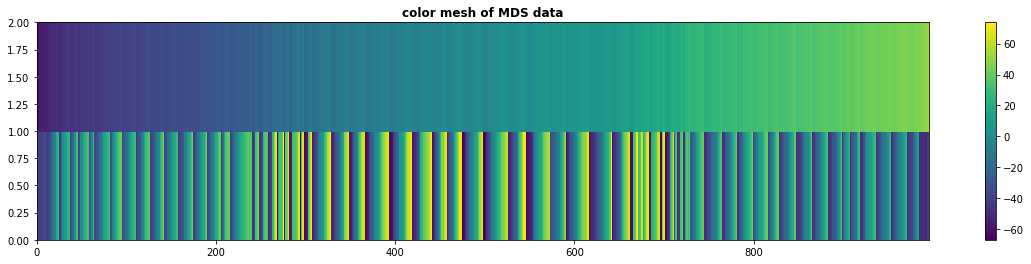

In [60]:
plt.figure(figsize=(20, 4))
# c= plt.pcolormesh(mds[:15, :15])
c= plt.pcolormesh(matrix.T)
plt.colorbar(c)  
plt.title('color mesh of MDS data', fontweight ="bold")
plt.show()

### Report the map you recovered in the form of a scatter plot.

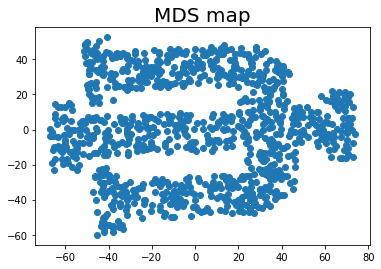

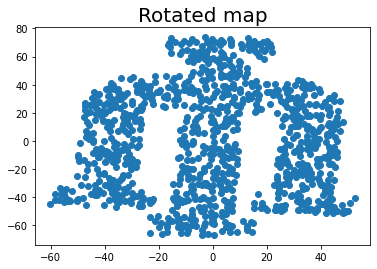

In [61]:
plt.scatter(matrix[:,0], matrix[:,1], )
plt.title('MDS map', fontsize =20)
plt.show()


plt.scatter(matrix[:,1], matrix[:,0], )
plt.title('Rotated map', fontsize =20)
plt.show()

## **Final: Convert the notebook to HTML**

In [62]:
# %%shell
# jupyter nbconvert --to html /content/AG_MLSP_SP22_HW_4.ipynb

# **The END**